In [48]:
import pandas as pd
import ast
import datetime
from google.colab import drive
import matplotlib.pyplot as plt
import randan
from randan.tools import coLabAdaptor, textPreprocessor, vectorizer
from tqdm.notebook import tqdm
from tqdm import tqdm
from transformers import pipeline
import pymystem3
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/matroskin/matroskin_wall_posts_new.csv') #импортируем данные со всеми постами приюта Матроскин
df

/tmp/ipython-input-4112925609.py:1: DtypeWarning: Columns (27,28,29,32,35,40,41,42,43,44,47,48,49,51,52,53,55,56,58) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/matroskin/matroskin_wall_posts_new.csv') #импортируем данные со всеми постами приюта Матроскин


,Unnamed: 0,inner_type,is_pinned,marked_as_ads,hash,type,carousel_offset,attachments,date,edited,...,geo.place.address,copy_history,copyright.link,copyright.name,copyright.type,copyright.id,geo.place.city,marked_as_author_ad,geo.showmap,zoom_text
0,0,wall_wallpost,1.0,0,8RnWqRsW-MplV4_-4w,post,0.0,"[{'type': 'video', 'video': {'response_type': ...",1756473114,1.756473e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,wall_wallpost,NaN,0,Rk2V8bS4QFmJ-xAPUg,post,0.0,"[{'type': 'photo', 'photo': {'album_id': -7, '...",1756893666,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,wall_wallpost,NaN,0,RbxqxxB3Vrb7RbsvFw,post,0.0,"[{'type': 'photo', 'photo': {'album_id': -7, '...",1756886400,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,wall_wallpost,NaN,0,WkbdtFPac0oIzta9cQ,post,0.0,"[{'type': 'photo', 'photo': {'album_id': -7, '...",1756879200,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,wall_wallpost,NaN,0,VYLt4iD435BxiOl4Dw,post,0.0,"[{'type': 'photo', 'photo': {'album_id': -7, '...",1756814400,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33647,33647,wall_wallpost,NaN,0,Ef5vtKVKCf3ol-f8Rg,post,NaN,[],1299671436,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
33648,33648,wall_wallpost,NaN,0,A8NRIHWmN53a-l-ycg,post,NaN,[],1298824260,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
33649,33649,wall_wallpost,NaN,0,4zhZwvIfiPiGrFDWeg,post,NaN,[],1298824149,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33650,33650,wall_wallpost,NaN,0,44iKVss8RK_bRuTGjg,post,NaN,[],1298824114,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [ ]:
def parse_attachments(cell):
    # Преобразует строку с вложениями в Python-объект
    # Если неудачно — возвращает пустой результат
    # Извлекает тип вложения и данные видео (если есть)
    try:
        attachments = ast.literal_eval(cell)
    except Exception:
        return pd.Series()

    data = {}
    if isinstance(attachments, list) and attachments:
        for att in attachments:
            if 'type' in att:
                data['type'] = att['type']
            if att.get('type') == 'video' and 'video' in att:
                # Добавляем детали видео с префиксом video_
                for key, value in att['video'].items():
                    data[f'video_{key}'] = value
    return pd.Series(data)

# Разбираем колонку 'attachments' и добавляем извлечённые данные в DataFrame
df_parsed = df['attachments'].apply(parse_attachments)
df = pd.concat([df, df_parsed], axis=1)

In [ ]:
df.columns

Index(['Unnamed: 0', 'inner_type', 'is_pinned', 'marked_as_ads', 'hash',
       'type', 'carousel_offset', 'attachments', 'date', 'edited', 'from_id',
       'id', 'reaction_set_id', 'owner_id', 'post_type', 'text',
       'donut.is_donut', 'comments.count', 'push_subscription.is_subscribed',
       'likes.can_like', 'likes.count', 'likes.user_likes', 'reactions.count',
       'reactions.items', 'reposts.count', 'views.count', 'signer_id',
       'check_sign', 'geo.coordinates', 'geo.place.discriminator',
       'geo.place.created', 'geo.place.id', 'geo.place.is_deleted',
       'geo.place.latitude', 'geo.place.longitude', 'geo.place.title',
       'geo.place.total_checkins', 'geo.place.updated', 'geo.place.category',
       'geo.place.category_object.id', 'geo.place.category_object.title',
       'geo.place.category_object.icons', 'geo.type', 'coowners.is_owner',
       'coowners.is_coowner', 'coowners.coowner_post_id.owner_id',
       'coowners.coowner_post_id.post_id', 'coowners.lis

In [ ]:
df_filtered = df[['date', 'text',
    'comments.count', 'likes.count',
    'reposts.count', 'views.count', 'id']] #отбираем только интересующие переменные
df_filtered

,date,text,comments.count,likes.count,reposts.count,views.count,id
0,1756473114,Этого светлячка зовут Чапек. И каждую минуту е...,139,1710,38,6018.0,267316
1,1756893666,Самый добрый фестиваль [club232253162|КОТОПЁC]...,0,12,2,147.0,267619
2,1756886400,#ищу_дом@matroskinperm \n \nПрекрасная Сиеста ...,0,42,2,419.0,267612
3,1756879200,Оказываем информационную помощь. Кошка не явля...,0,75,9,1090.0,267606
4,1756814400,#ищу_дом@matroskinperm \n \nЛюбопытная Феста и...,0,74,7,857.0,267583
...,...,...,...,...,...,...,...
33647,1299671436,http://periscop.prpc.ru/index.php?option=com_c...,0,0,0,NaN,1604
33648,1298824260,у нашей организации появился свой живой журнал...,0,6,1,NaN,1594
33649,1298824149,"ZZZ на выставке ""Кошкин дом"" (5-6 февраля) - и...",0,0,0,NaN,1593
33650,1298824114,"ZZZ на выставке ""Кошкин дом"" (5-6 февраля) - и...",0,0,0,NaN,1592


In [ ]:
# Функция для преобразования timestamp (в секундах) в datetime
def timestamp_to_datetime(ts):
    # Если ts уже Timestamp, конвертируем в float seconds
    if isinstance(ts, pd.Timestamp):
        return datetime.datetime.fromtimestamp(ts.timestamp())
    else:
        return datetime.datetime.fromtimestamp(ts)
df_filtered['date'] = df_filtered['date'].apply(timestamp_to_datetime) #преобразуем поле'date'из формата timestamp в datetime

/tmp/ipython-input-2621567224.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['date'] = df_filtered['date'].apply(timestamp_to_datetime) #преобразуем поле'date'из формата timestamp в datetime


In [ ]:
df_filtered

,date,text,comments.count,likes.count,reposts.count,views.count,id
0,2025-08-29 13:11:54,Этого светлячка зовут Чапек. И каждую минуту е...,139,1710,38,6018.0,267316
1,2025-09-03 10:01:06,Самый добрый фестиваль [club232253162|КОТОПЁC]...,0,12,2,147.0,267619
2,2025-09-03 08:00:00,#ищу_дом@matroskinperm \n \nПрекрасная Сиеста ...,0,42,2,419.0,267612
3,2025-09-03 06:00:00,Оказываем информационную помощь. Кошка не явля...,0,75,9,1090.0,267606
4,2025-09-02 12:00:00,#ищу_дом@matroskinperm \n \nЛюбопытная Феста и...,0,74,7,857.0,267583
...,...,...,...,...,...,...,...
33647,2011-03-09 11:50:36,http://periscop.prpc.ru/index.php?option=com_c...,0,0,0,NaN,1604
33648,2011-02-27 16:31:00,у нашей организации появился свой живой журнал...,0,6,1,NaN,1594
33649,2011-02-27 16:29:09,"ZZZ на выставке ""Кошкин дом"" (5-6 февраля) - и...",0,0,0,NaN,1593
33650,2011-02-27 16:28:34,"ZZZ на выставке ""Кошкин дом"" (5-6 февраля) - и...",0,0,0,NaN,1592


In [ ]:
# поскольку данные начинаются с 2011 года, то было принято решение найти минимальную дату непустых Просмтров, так как эта переменная не сразу записывалась
first_notnull = df_filtered.loc[df_filtered['views.count'].notna(), 'date'].min()
print("Первая дата с доступными просмотрами:", first_notnull)

Первая дата с доступными просмотрами: 2017-01-01 06:13:00


In [ ]:
df_filtered = df_filtered[df_filtered['date'] >= '2017-01-01'] #берем только строки с начала 2017 года, так как показатель Просмотры начал записываться только в тот момент
df_filtered

,date,text,comments.count,likes.count,reposts.count,views.count,id
0,2025-08-29 13:11:54,Этого светлячка зовут Чапек. И каждую минуту е...,139,1710,38,6018.0,267316
1,2025-09-03 10:01:06,Самый добрый фестиваль [club232253162|КОТОПЁC]...,0,12,2,147.0,267619
2,2025-09-03 08:00:00,#ищу_дом@matroskinperm \n \nПрекрасная Сиеста ...,0,42,2,419.0,267612
3,2025-09-03 06:00:00,Оказываем информационную помощь. Кошка не явля...,0,75,9,1090.0,267606
4,2025-09-02 12:00:00,#ищу_дом@matroskinperm \n \nЛюбопытная Феста и...,0,74,7,857.0,267583
...,...,...,...,...,...,...,...
20425,2017-01-02 08:12:01,"Очередное доказательство того, что коты — это ...",1,73,3,2812.0,50002
20426,2017-01-02 06:06:03,#ищу_дом@zzzperm \nМышка ищет дом без других п...,0,29,6,1733.0,50001
20427,2017-01-01 10:13:00,#ищу_дом@zzzperm \nМорис ищет дом! \nОн очень ...,0,26,4,1838.0,49987
20428,2017-01-01 08:05:16,Мы без капельки смущения \nШлем кошачьи поздра...,0,65,6,2270.0,49986


In [ ]:
df_filtered.dtypes

,0
date,datetime64[ns]
text,object
comments.count,int64
likes.count,int64
reposts.count,int64
views.count,float64
id,int64


In [ ]:
# Посчитаем описательную статистику для количественных переменных
columns = ['comments.count', 'likes.count', 'reposts.count', 'views.count']

# Получаем базовую описательную статистику
stats = df_filtered[columns].describe()

# Вычисляем медиану и дисперсию
median = df_filtered[columns].median()
variance = df_filtered[columns].var()
# Мода — берем первое значение (возможны несколько мод)
mode = df_filtered[columns].mode().iloc[0]

# Добавляем новые строки с медианой и дисперсией в таблицу
stats.loc['median'] = median
stats.loc['variance'] = variance
stats.loc['mode'] = mode
stats

,comments.count,likes.count,reposts.count,views.count
count,20430.000000,2.043000e+04,20430.000000,2.043000e+04
mean,7.796231,2.525372e+02,17.325942,3.748006e+03
std,32.660338,1.863656e+03,24.435526,3.716374e+03
min,0.000000,1.000000e+00,0.000000,1.470000e+02
25%,0.000000,5.300000e+01,7.000000,2.097000e+03
50%,2.000000,9.900000e+01,12.000000,2.856000e+03
75%,6.000000,1.630000e+02,20.000000,4.183750e+03
max,1344.000000,7.231400e+04,1638.000000,1.294630e+05
median,2.000000,9.900000e+01,12.000000,2.856000e+03
variance,1066.697670,3.473213e+06,597.094941,1.381143e+07


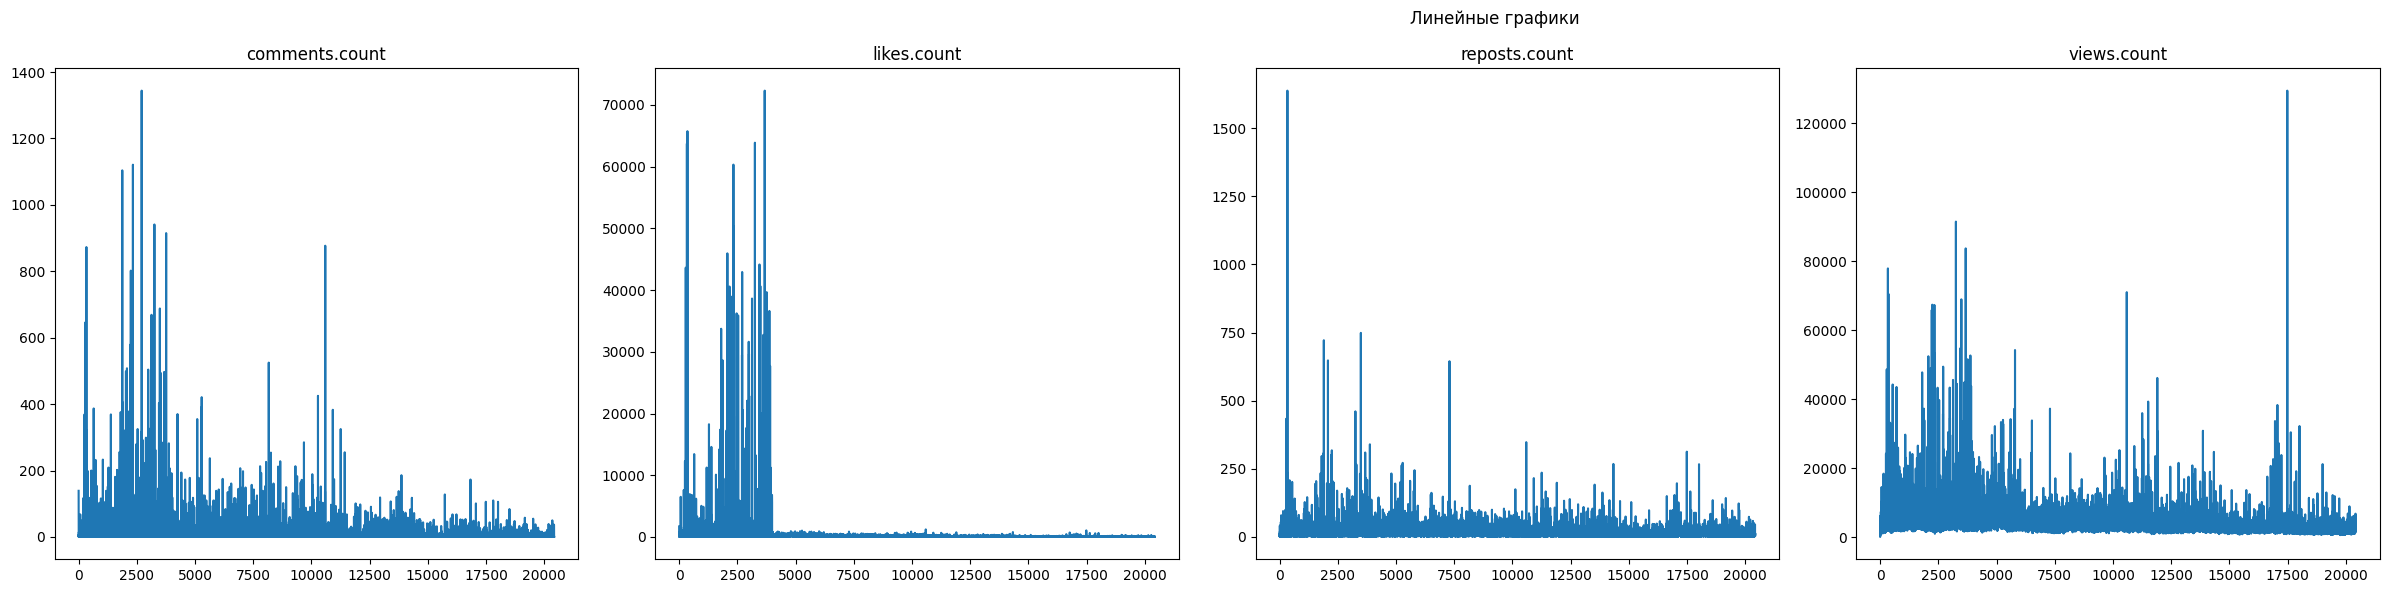

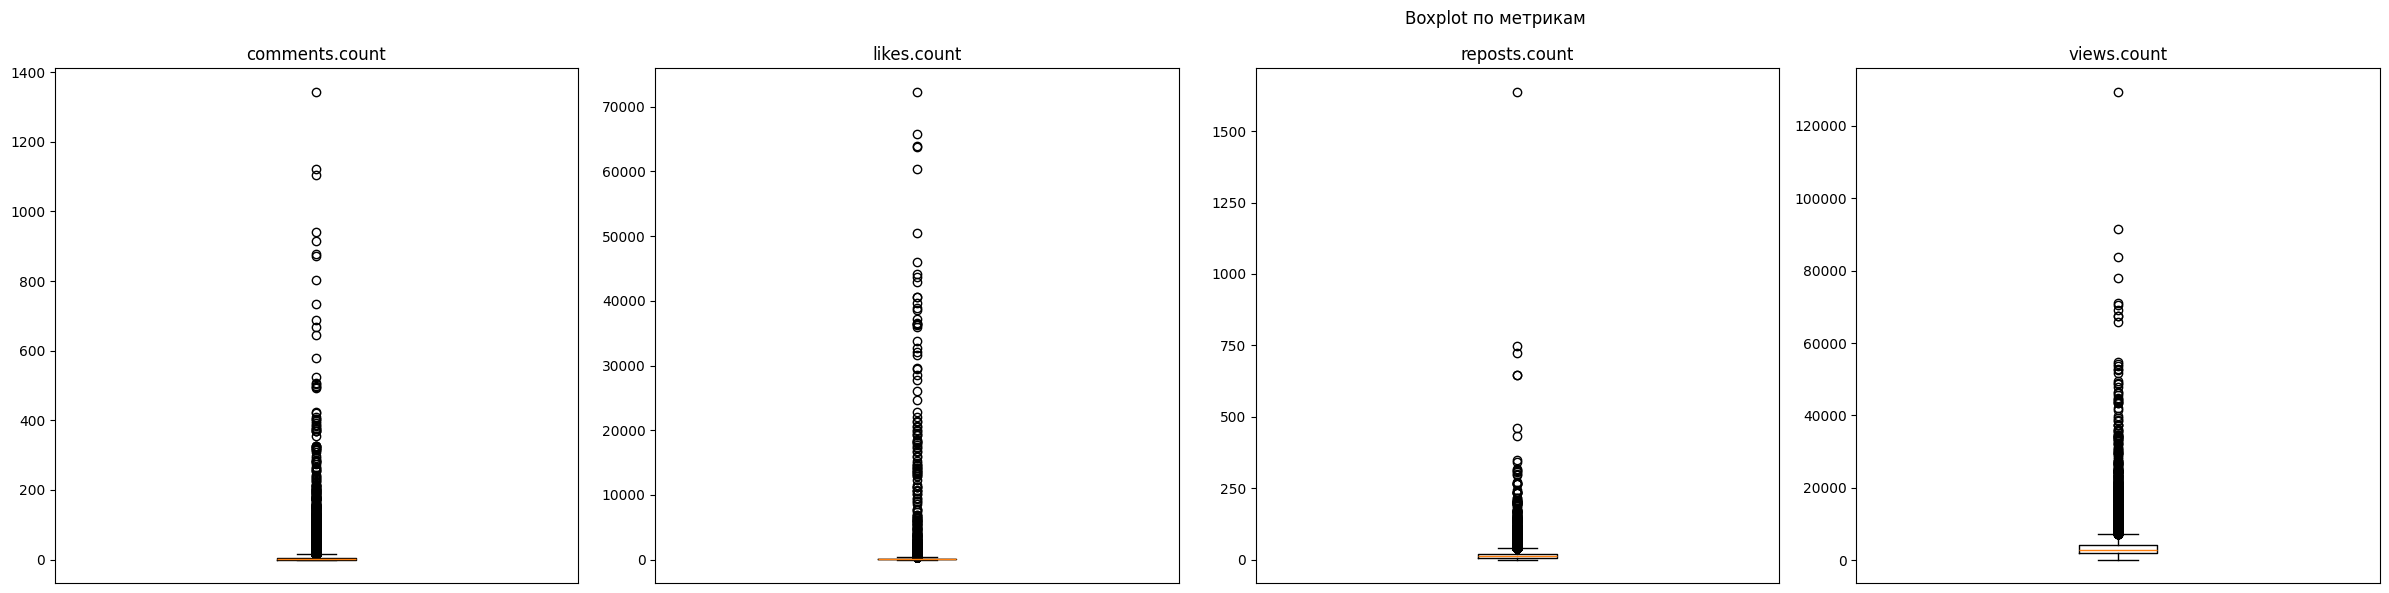

In [ ]:
selected_columns = df_filtered[columns]

# Строим линейные графики для каждого столбца
plt.figure(figsize=(30, 6))
for i, col in enumerate(columns):
    plt.subplot(1, 5, i + 1)
    plt.plot(selected_columns[col].dropna())
    plt.title(col)
plt.suptitle('Линейные графики')
plt.tight_layout()
plt.show()

# Строим boxplot (ящик с усами) для каждого столбца
plt.figure(figsize=(30, 6))
for i, col in enumerate(columns):
    plt.subplot(1, 5, i + 1)
    plt.boxplot(selected_columns[col].dropna())
    plt.title(col)
    plt.xticks([])
plt.suptitle('Boxplot по метрикам')
plt.tight_layout()
plt.show()

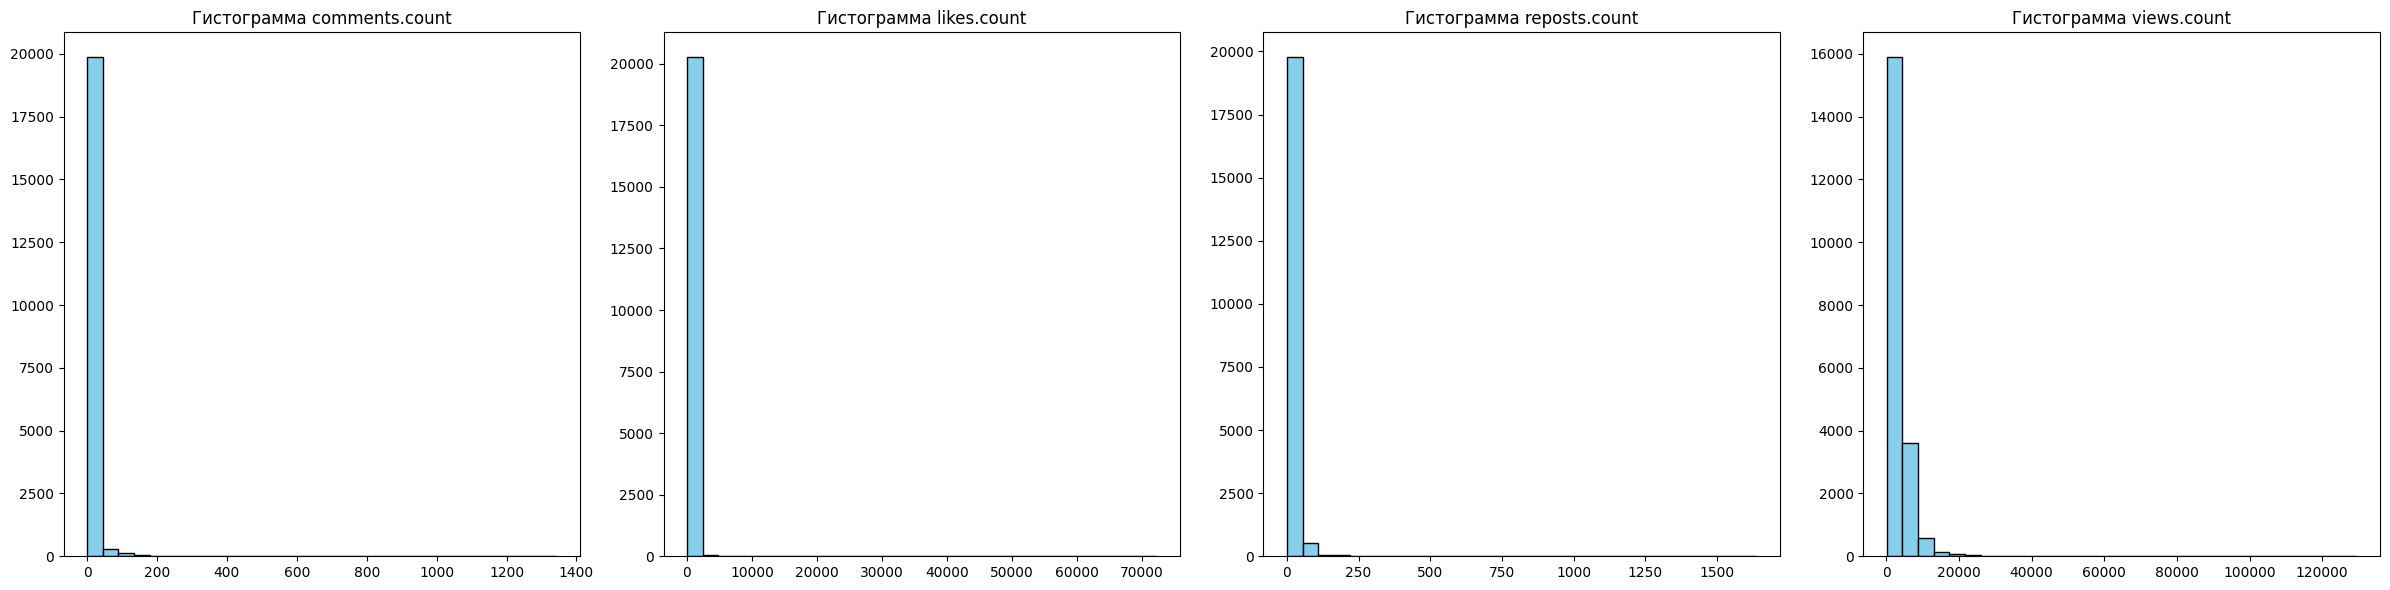

In [ ]:
# Нарисуем гистограмму для каждого столбца
plt.figure(figsize=(30, 6))
for i, col in enumerate(columns):
    plt.subplot(1, 5, i + 1)
    plt.hist(selected_columns[col].dropna(), bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Гистограмма {col}')
plt.tight_layout()
plt.show()

In [ ]:
# Поскольку данные все имеют выбросы, было принято решение заменить их на медиану
for col in columns:
    # Находим первый квартиль (Q1) - значение на 25-м процентиле
    Q1 = selected_columns[col].quantile(0.25)
    # Находим третий квартиль (Q3) - значение на 75-м процентиле
    Q3 = selected_columns[col].quantile(0.75)
    # Вычисляем межквартильный размах (IQR)
    IQR = Q3 - Q1

    # Определяем нижнюю границу для выбросов как Q1 - 1.5 * IQR
    lower_bound = Q1 - 1.5 * IQR
    # Определяем верхнюю границу для выбросов как Q3 + 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Находим медиану столбца для замены выбросов
    median_value = selected_columns[col].median()

    # Создаем копию столбца, чтобы избежать предупреждений SettingWithCopyWarning
    series = selected_columns[col].copy()

    # Проходим по каждому значению столбца:
    # если значение выходит за пределы [lower_bound, upper_bound], заменяем его на медиану,
    # иначе оставляем без изменений
    selected_columns[col] = series.apply(
        lambda x: median_value if (x < lower_bound or x > upper_bound) else x
    )

/tmp/ipython-input-2227293452.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_columns[col] = series.apply(
/tmp/ipython-input-2227293452.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_columns[col] = series.apply(
/tmp/ipython-input-2227293452.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

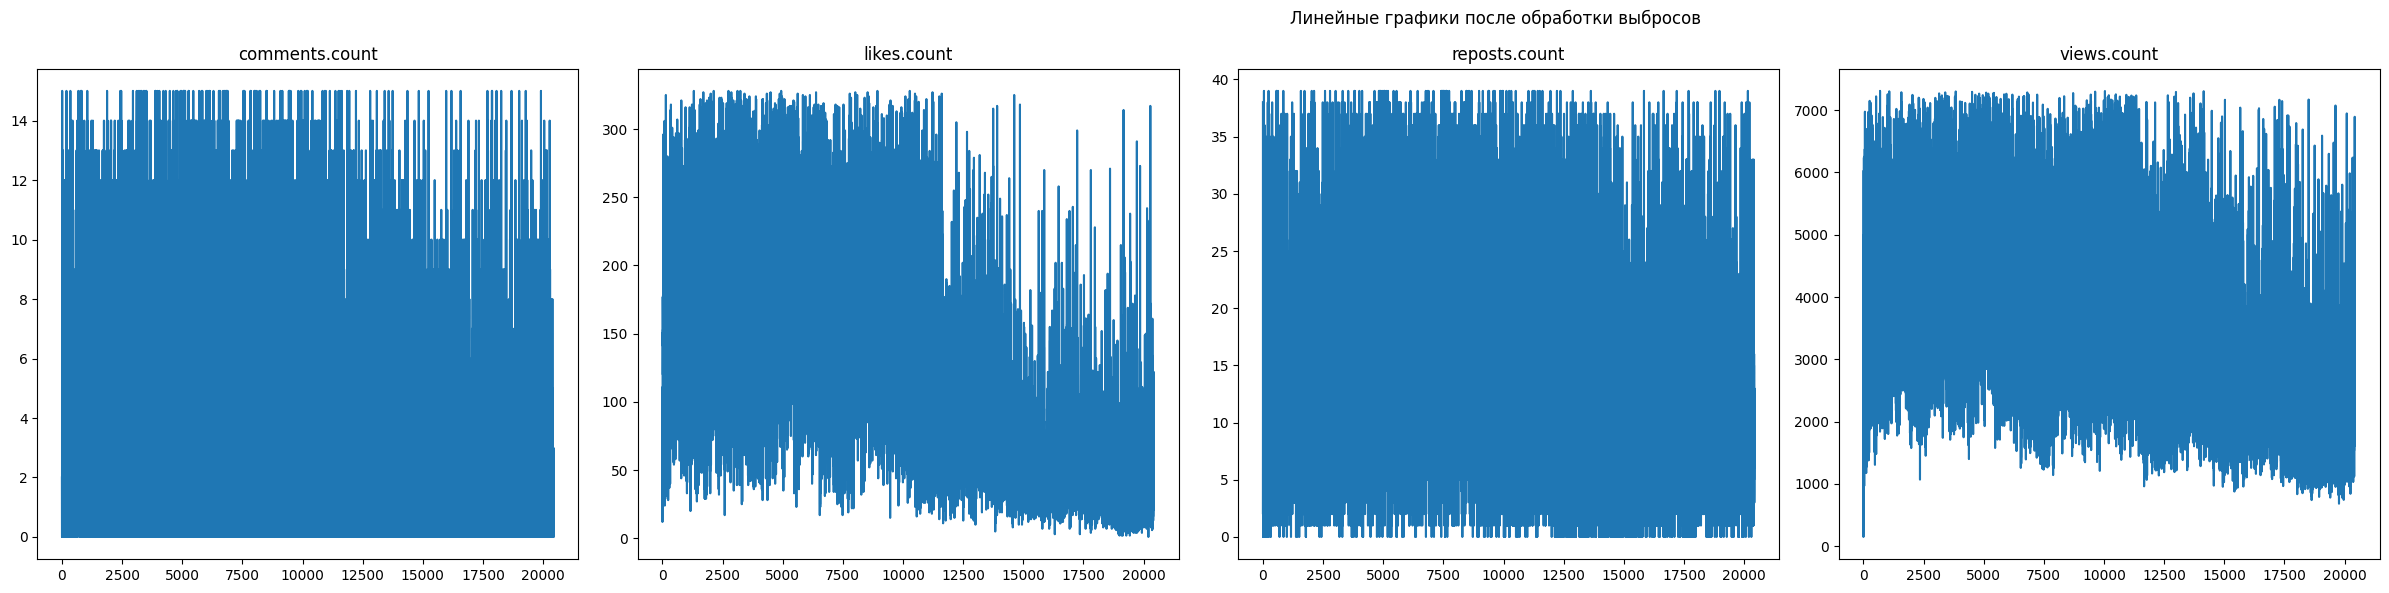

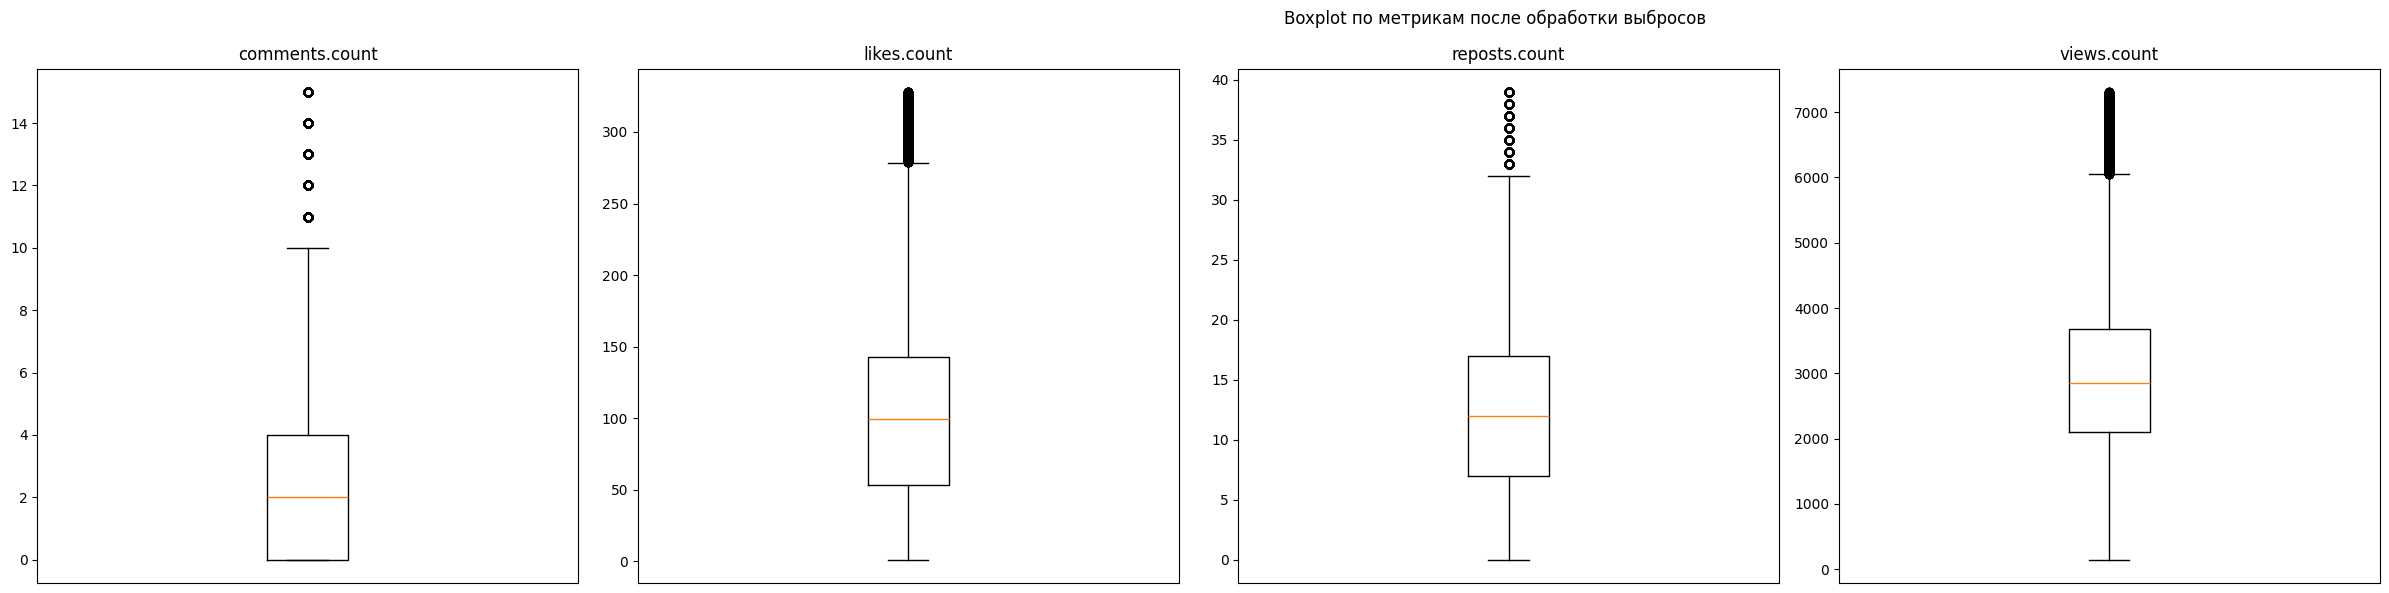

In [ ]:
# Линейные графики после замены выбросов
plt.figure(figsize=(30, 6))
for i, col in enumerate(columns):
    plt.subplot(1, 5, i + 1)
    plt.plot(selected_columns[col].dropna())
    plt.title(col)
plt.suptitle('Линейные графики после обработки выбросов')
plt.tight_layout()
plt.show()

# Boxplot после замены выбросов
plt.figure(figsize=(30, 6))
for i, col in enumerate(columns):
    plt.subplot(1, 5, i + 1)
    plt.boxplot(selected_columns[col].dropna())
    plt.title(col)
    plt.xticks([])
plt.suptitle('Boxplot по метрикам после обработки выбросов')
plt.tight_layout()
plt.show()

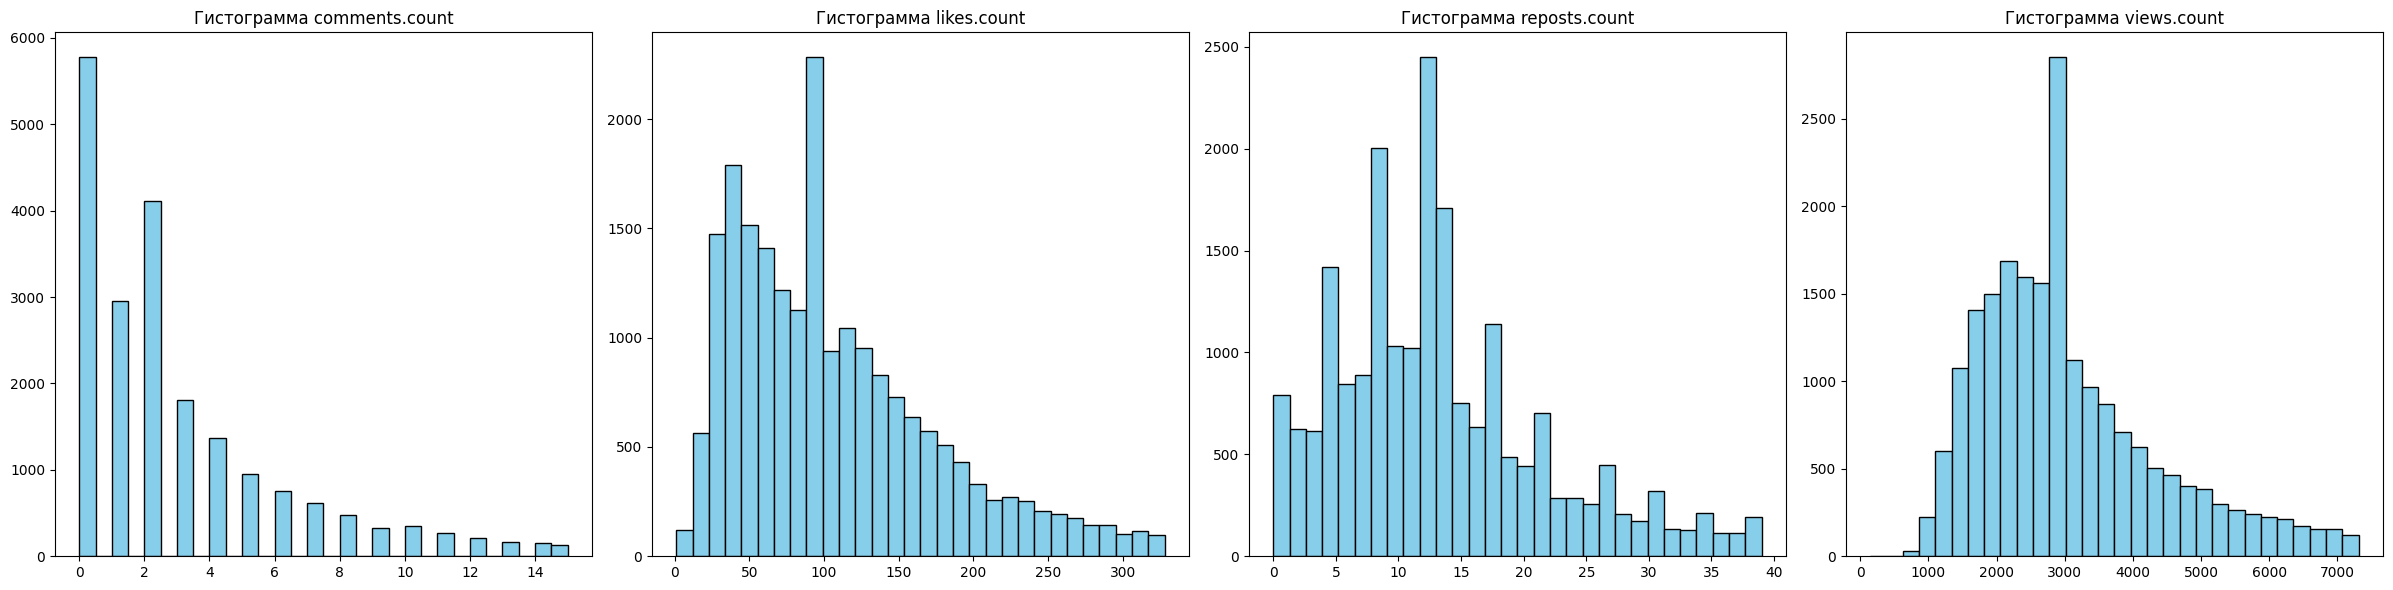

In [ ]:
plt.figure(figsize=(30, 6))
for i, col in enumerate(columns):
    plt.subplot(1, 5, i + 1)
    plt.hist(selected_columns[col].dropna(), bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Гистограмма {col}')
plt.tight_layout()
plt.show()

In [ ]:
for col in selected_columns.columns: # копируем выбранные столбцы из selected_columns обратно в основной датафрейм
    df_filtered[col] = selected_columns[col]

/tmp/ipython-input-932309906.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[col] = selected_columns[col]


In [ ]:
df_filtered

,date,text,comments.count,likes.count,reposts.count,views.count,id
0,2025-08-29 13:11:54,Этого светлячка зовут Чапек. И каждую минуту е...,2.0,99.0,38.0,6018.0,267316
1,2025-09-03 10:01:06,Самый добрый фестиваль [club232253162|КОТОПЁC]...,0.0,12.0,2.0,147.0,267619
2,2025-09-03 08:00:00,#ищу_дом@matroskinperm \n \nПрекрасная Сиеста ...,0.0,42.0,2.0,419.0,267612
3,2025-09-03 06:00:00,Оказываем информационную помощь. Кошка не явля...,0.0,75.0,9.0,1090.0,267606
4,2025-09-02 12:00:00,#ищу_дом@matroskinperm \n \nЛюбопытная Феста и...,0.0,74.0,7.0,857.0,267583
...,...,...,...,...,...,...,...
20425,2017-01-02 08:12:01,"Очередное доказательство того, что коты — это ...",1.0,73.0,3.0,2812.0,50002
20426,2017-01-02 06:06:03,#ищу_дом@zzzperm \nМышка ищет дом без других п...,0.0,29.0,6.0,1733.0,50001
20427,2017-01-01 10:13:00,#ищу_дом@zzzperm \nМорис ищет дом! \nОн очень ...,0.0,26.0,4.0,1838.0,49987
20428,2017-01-01 08:05:16,Мы без капельки смущения \nШлем кошачьи поздра...,0.0,65.0,6.0,2270.0,49986


In [ ]:
# Удаляем дубликаты по столбцу 'text', оставляем первое вхождение
df_filtered = df_filtered.drop_duplicates(subset='text', keep='first')
df_filtered

,date,text,comments.count,likes.count,reposts.count,views.count,id
0,2025-08-29 13:11:54,Этого светлячка зовут Чапек. И каждую минуту е...,2.0,99.0,38.0,6018.0,267316
1,2025-09-03 10:01:06,Самый добрый фестиваль [club232253162|КОТОПЁC]...,0.0,12.0,2.0,147.0,267619
2,2025-09-03 08:00:00,#ищу_дом@matroskinperm \n \nПрекрасная Сиеста ...,0.0,42.0,2.0,419.0,267612
3,2025-09-03 06:00:00,Оказываем информационную помощь. Кошка не явля...,0.0,75.0,9.0,1090.0,267606
4,2025-09-02 12:00:00,#ищу_дом@matroskinperm \n \nЛюбопытная Феста и...,0.0,74.0,7.0,857.0,267583
...,...,...,...,...,...,...,...
20422,2017-01-02 15:05:12,"«Дельфины не любят развлекать зрителей, но дел...",0.0,24.0,7.0,1985.0,50007
20423,2017-01-02 13:09:02,Юный Адольф надеется на встречу с самым лучшим...,3.0,30.0,7.0,1896.0,50005
20424,2017-01-02 10:07:00,#ищу_дом@zzzperm \nЧерныш ждет доброе человече...,0.0,33.0,13.0,1926.0,50004
20425,2017-01-02 08:12:01,"Очередное доказательство того, что коты — это ...",1.0,73.0,3.0,2812.0,50002


In [ ]:
df_filtered = df_filtered.dropna(subset=['text']) # удаляем посты без текста, так как в рамках исследования они не несут ценность
df_filtered

,date,text,comments.count,likes.count,reposts.count,views.count,id
0,2025-08-29 13:11:54,Этого светлячка зовут Чапек. И каждую минуту е...,2.0,99.0,38.0,6018.0,267316
1,2025-09-03 10:01:06,Самый добрый фестиваль [club232253162|КОТОПЁC]...,0.0,12.0,2.0,147.0,267619
2,2025-09-03 08:00:00,#ищу_дом@matroskinperm \n \nПрекрасная Сиеста ...,0.0,42.0,2.0,419.0,267612
3,2025-09-03 06:00:00,Оказываем информационную помощь. Кошка не явля...,0.0,75.0,9.0,1090.0,267606
4,2025-09-02 12:00:00,#ищу_дом@matroskinperm \n \nЛюбопытная Феста и...,0.0,74.0,7.0,857.0,267583
...,...,...,...,...,...,...,...
20422,2017-01-02 15:05:12,"«Дельфины не любят развлекать зрителей, но дел...",0.0,24.0,7.0,1985.0,50007
20423,2017-01-02 13:09:02,Юный Адольф надеется на встречу с самым лучшим...,3.0,30.0,7.0,1896.0,50005
20424,2017-01-02 10:07:00,#ищу_дом@zzzperm \nЧерныш ждет доброе человече...,0.0,33.0,13.0,1926.0,50004
20425,2017-01-02 08:12:01,"Очередное доказательство того, что коты — это ...",1.0,73.0,3.0,2812.0,50002


In [ ]:
# Функция для определения времени суток
def get_time_of_day(hour):
    if 6 <= hour < 12:
        return 'утро'
    elif 12 <= hour < 18:
        return 'день'
    elif 18 <= hour < 23:
        return 'вечер'
    else:
        return 'ночь'

# Создаем признаки
df_filtered['hour'] = df_filtered['date'].dt.hour
df_filtered['time_of_day'] = df_filtered['hour'].apply(get_time_of_day)
df_filtered['day_of_week'] = df_filtered['date'].dt.dayofweek  # 0=понедельник, 6=воскресенье
df_filtered['month'] = df_filtered['date'].dt.month
df_filtered['is_weekend'] = df_filtered['day_of_week'].isin([5, 6])  # True, если выходной (сб, вс)

# Функция определения сезона по месяцу (для России/средней полосы)
def get_season(month):
    if month in [12, 1, 2]:
        return 'зима'
    elif month in [3, 4, 5]:
        return 'весна'
    elif month in [6, 7, 8]:
        return 'лето'
    else:
        return 'осень'

df_filtered['season'] = df_filtered['month'].apply(get_season)

/tmp/ipython-input-3532284041.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['hour'] = df_filtered['date'].dt.hour
/tmp/ipython-input-3532284041.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['time_of_day'] = df_filtered['hour'].apply(get_time_of_day)
/tmp/ipython-input-3532284041.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [ ]:
df_filtered

,date,text,comments.count,likes.count,reposts.count,views.count,id,hour,time_of_day,day_of_week,month,is_weekend,season
0,2025-08-29 13:11:54,Этого светлячка зовут Чапек. И каждую минуту е...,2.0,99.0,38.0,6018.0,267316,13,день,4,8,False,лето
1,2025-09-03 10:01:06,Самый добрый фестиваль [club232253162|КОТОПЁC]...,0.0,12.0,2.0,147.0,267619,10,утро,2,9,False,осень
2,2025-09-03 08:00:00,#ищу_дом@matroskinperm \n \nПрекрасная Сиеста ...,0.0,42.0,2.0,419.0,267612,8,утро,2,9,False,осень
3,2025-09-03 06:00:00,Оказываем информационную помощь. Кошка не явля...,0.0,75.0,9.0,1090.0,267606,6,утро,2,9,False,осень
4,2025-09-02 12:00:00,#ищу_дом@matroskinperm \n \nЛюбопытная Феста и...,0.0,74.0,7.0,857.0,267583,12,день,1,9,False,осень
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20422,2017-01-02 15:05:12,"«Дельфины не любят развлекать зрителей, но дел...",0.0,24.0,7.0,1985.0,50007,15,день,0,1,False,зима
20423,2017-01-02 13:09:02,Юный Адольф надеется на встречу с самым лучшим...,3.0,30.0,7.0,1896.0,50005,13,день,0,1,False,зима
20424,2017-01-02 10:07:00,#ищу_дом@zzzperm \nЧерныш ждет доброе человече...,0.0,33.0,13.0,1926.0,50004,10,утро,0,1,False,зима
20425,2017-01-02 08:12:01,"Очередное доказательство того, что коты — это ...",1.0,73.0,3.0,2812.0,50002,8,утро,0,1,False,зима


Приступаем к текстовой предобоработке данных для того, чтобы затем провести сентимент анализ постов

In [ ]:
tqdm.pandas()
# Очищаем текст от лишних символов
def safe_clean(text):
    try:
        if not text or len(text.strip()) == 0:
            return ""
        cleaned_text = textPreprocessor.simbolsCleaner(text)
        # Если после очистки текст пустой, возвращаем пустую строку
        if not cleaned_text or len(cleaned_text) == 0:
            return ""
        return cleaned_text
    except Exception as e:
        print(f"Error processing text: {text[:30]}... - {e}")
        return ""

df_filtered.loc[:, 'textPreprocessed'] = df_filtered['text'].progress_apply(safe_clean)

df_filtered

 32%|███▏      | 4567/14063 [00:00<00:01, 6453.09it/s]

Error processing text: ❤️... - string index out of range
Error processing text: 🙏🏻... - string index out of range
Error processing text: ❤️❤️... - string index out of range


 43%|████▎     | 6017/14063 [00:00<00:01, 6840.50it/s]

Error processing text: ❤... - string index out of range


 68%|██████▊   | 9600/14063 [00:01<00:00, 6615.82it/s]

Error processing text: 🤪... - string index out of range
Error processing text: 😄... - string index out of range
Error processing text: 🙏... - string index out of range
Error processing text: 💚... - string index out of range
Error processing text: 🐱❤️... - string index out of range
Error processing text: ✨... - string index out of range


 91%|█████████ | 12829/14063 [00:01<00:00, 7033.11it/s]

Error processing text: 😅... - string index out of range
Error processing text: 😹... - string index out of range
Error processing text: 😊... - string index out of range


100%|██████████| 14063/14063 [00:02<00:00, 6832.12it/s]
/tmp/ipython-input-343689462.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.loc[:, 'textPreprocessed'] = df_filtered['text'].progress_apply(safe_clean)


Error processing text: 😎... - string index out of range


,date,text,comments.count,likes.count,reposts.count,views.count,id,hour,time_of_day,day_of_week,month,is_weekend,season,textPreprocessed
0,2025-08-29 13:11:54,Этого светлячка зовут Чапек. И каждую минуту е...,2.0,99.0,38.0,6018.0,267316,13,день,4,8,False,лето,Этого светлячка зовут Чапек И каждую минуту ег...
1,2025-09-03 10:01:06,Самый добрый фестиваль [club232253162|КОТОПЁC]...,0.0,12.0,2.0,147.0,267619,10,утро,2,9,False,осень,Самый добрый фестиваль club232253162 КОТОПЁC у...
2,2025-09-03 08:00:00,#ищу_дом@matroskinperm \n \nПрекрасная Сиеста ...,0.0,42.0,2.0,419.0,267612,8,утро,2,9,False,осень,ищу дом matroskinperm Прекрасная Сиеста ищет д...
3,2025-09-03 06:00:00,Оказываем информационную помощь. Кошка не явля...,0.0,75.0,9.0,1090.0,267606,6,утро,2,9,False,осень,Оказываем информационную помощь Кошка не являе...
4,2025-09-02 12:00:00,#ищу_дом@matroskinperm \n \nЛюбопытная Феста и...,0.0,74.0,7.0,857.0,267583,12,день,1,9,False,осень,ищу дом matroskinperm Любопытная Феста ищет до...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20422,2017-01-02 15:05:12,"«Дельфины не любят развлекать зрителей, но дел...",0.0,24.0,7.0,1985.0,50007,15,день,0,1,False,зима,Дельфины не любят развлекать зрителей но делаю...
20423,2017-01-02 13:09:02,Юный Адольф надеется на встречу с самым лучшим...,3.0,30.0,7.0,1896.0,50005,13,день,0,1,False,зима,Юный Адольф надеется на встречу с самым лучшим...
20424,2017-01-02 10:07:00,#ищу_дом@zzzperm \nЧерныш ждет доброе человече...,0.0,33.0,13.0,1926.0,50004,10,утро,0,1,False,зима,ищу дом zzzperm Черныш ждет доброе человеческо...
20425,2017-01-02 08:12:01,"Очередное доказательство того, что коты — это ...",1.0,73.0,3.0,2812.0,50002,8,утро,0,1,False,зима,Очередное доказательство того что коты это жид...


In [ ]:
# Лемматизируем текст по частям

chunk_size = 500
results = []

for start in tqdm(range(0, len(df_filtered), chunk_size)):
    chunk = df_filtered.iloc[start:start+chunk_size]
    processed_chunk = textPreprocessor.pymystemLemmatizer(chunk, 'textPreprocessed')
    results.append(processed_chunk)

df_filtered['textPreprocessed'] = pd.concat(results)

100%|██████████| 29/29 [02:55<00:00,  6.04s/it]
/tmp/ipython-input-2235934942.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['textPreprocessed'] = pd.concat(results)


In [ ]:
# Очищаем тексты от стоп слов
df_filtered['textPreprocessed'] = df_filtered['textPreprocessed'].progress_apply(lambda text: textPreprocessor.stopwordsDropper(text))

100%|██████████| 14063/14063 [00:07<00:00, 1935.59it/s]
/tmp/ipython-input-2018548546.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['textPreprocessed'] = df_filtered['textPreprocessed'].progress_apply(lambda text: textPreprocessor.stopwordsDropper(text))


In [ ]:
df_filtered

,date,text,comments.count,likes.count,reposts.count,views.count,id,hour,time_of_day,day_of_week,month,is_weekend,season,textPreprocessed
0,2025-08-29 13:11:54,Этого светлячка зовут Чапек. И каждую минуту е...,2.0,99.0,38.0,6018.0,267316,13,день,4,8,False,лето,светлячок звать чапек минута мозг превращаться...
1,2025-09-03 10:01:06,Самый добрый фестиваль [club232253162|КОТОПЁC]...,0.0,12.0,2.0,147.0,267619,10,утро,2,9,False,осень,самый добрый фестиваль club232253162 котопес 7...
2,2025-09-03 08:00:00,#ищу_дом@matroskinperm \n \nПрекрасная Сиеста ...,0.0,42.0,2.0,419.0,267612,8,утро,2,9,False,осень,искать дом matroskinperm прекрасный сиеста иск...
3,2025-09-03 06:00:00,Оказываем информационную помощь. Кошка не явля...,0.0,75.0,9.0,1090.0,267606,6,утро,2,9,False,осень,оказывать информационный помощь кошка являться...
4,2025-09-02 12:00:00,#ищу_дом@matroskinperm \n \nЛюбопытная Феста и...,0.0,74.0,7.0,857.0,267583,12,день,1,9,False,осень,искать дом matroskinperm любопытный фест искат...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20422,2017-01-02 15:05:12,"«Дельфины не любят развлекать зрителей, но дел...",0.0,24.0,7.0,1985.0,50007,15,день,0,1,False,зима,дельфин любить развлекать зритель делать еда о...
20423,2017-01-02 13:09:02,Юный Адольф надеется на встречу с самым лучшим...,3.0,30.0,7.0,1896.0,50005,13,день,0,1,False,зима,юный адольф надеяться встреча самый хороший хо...
20424,2017-01-02 10:07:00,#ищу_дом@zzzperm \nЧерныш ждет доброе человече...,0.0,33.0,13.0,1926.0,50004,10,утро,0,1,False,зима,искать дом zzzperm черныш ждать добрый человеч...
20425,2017-01-02 08:12:01,"Очередное доказательство того, что коты — это ...",1.0,73.0,3.0,2812.0,50002,8,утро,0,1,False,зима,очередной доказательство кот жидкость


Проведем сентимент анализ

In [ ]:
# Загружаем модель для тонального анализа русского текста
sentiment_model = pipeline("text-classification", model="blanchefort/rubert-base-cased-sentiment")

# Инициализируем Mystem
mstem = pymystem3.Mystem()

# Функция для извлечения прилагательных из текста
def extract_adjectives(text):
    analysis = mstem.analyze(text)
    lexemes = []
    for token in analysis:
        if token.get('analysis'):
            gr = token['analysis'][0].get('gr', '')
            # Оставляем только прилагательные (обозначаются буквой 'A')
            if gr.startswith('A'):
                lex = token['analysis'][0].get('lex', '')
                if lex:
                    lexemes.append(lex)
    return ' '.join(lexemes)

# Применяем извлечение прилагательных к каждому тексту с прогрессом
tqdm.pandas()
df_filtered['adjectives'] = df_filtered['textPreprocessed'].astype(str).progress_apply(extract_adjectives)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


config.json:   0%|          | 0.00/943 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/711M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/499 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0
100%|██████████| 14063/14063 [00:35<00:00, 397.91it/s]
/tmp/ipython-input-1310114721.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['adjectives'] = df_filtered['textPreprocessed'].astype(str).progress_apply(extract_adjectives)


In [ ]:
# Функция для анализа тональности текста с обрезкой до 512 символов
def get_sentiment_score(text):
    if not text.strip():
        return 'neutral'  # Если текст пустой, считаем нейтральным
    try:
        result = sentiment_model(text[:512], truncation=True, max_length=512)[0]
        label = result['label']
        if label.lower() == 'positive':
            return 'positive'
        elif label.lower() == 'neutral':
            return 'neutral'
        elif label.lower() == 'negative':
            return 'negative'
        else:
            return label.lower()
    except Exception:
        return 'not_defined'

# Применяем анализ тональности к извлеченным прилагательным с прогрессом
df_filtered['sentiment_score'] = df_filtered['adjectives'].progress_apply(get_sentiment_score)

100%|██████████| 14063/14063 [02:01<00:00, 115.44it/s]
/tmp/ipython-input-690552674.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['sentiment_score'] = df_filtered['adjectives'].progress_apply(get_sentiment_score)


In [ ]:
df_filtered

,date,text,comments.count,likes.count,reposts.count,views.count,id,hour,time_of_day,day_of_week,month,is_weekend,season,textPreprocessed,adjectives,sentiment_score
0,2025-08-29 13:11:54,Этого светлячка зовут Чапек. И каждую минуту е...,2.0,99.0,38.0,6018.0,267316,13,день,4,8,False,лето,светлячок звать чапек минута мозг превращаться...,маленький частично зрительный сохранный малень...,neutral
1,2025-09-03 10:01:06,Самый добрый фестиваль [club232253162|КОТОПЁC]...,0.0,12.0,2.0,147.0,267619,10,утро,2,9,False,осень,самый добрый фестиваль club232253162 котопес 7...,самый добрый большой семейный бездомный добрый...,positive
2,2025-09-03 08:00:00,#ищу_дом@matroskinperm \n \nПрекрасная Сиеста ...,0.0,42.0,2.0,419.0,267612,8,утро,2,9,False,осень,искать дом matroskinperm прекрасный сиеста иск...,прекрасный хрупкий одиноко оживленный несчастн...,positive
3,2025-09-03 06:00:00,Оказываем информационную помощь. Кошка не явля...,0.0,75.0,9.0,1090.0,267606,6,утро,2,9,False,осень,оказывать информационный помощь кошка являться...,информационный предположительно персиковый сух...,neutral
4,2025-09-02 12:00:00,#ищу_дом@matroskinperm \n \nЛюбопытная Феста и...,0.0,74.0,7.0,857.0,267583,12,день,1,9,False,осень,искать дом matroskinperm любопытный фест искат...,любопытный похожий маленький бесконечный больш...,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20422,2017-01-02 15:05:12,"«Дельфины не любят развлекать зрителей, но дел...",0.0,24.0,7.0,1985.0,50007,15,день,0,1,False,зима,дельфин любить развлекать зритель делать еда о...,подобный российский антарктический бывший морс...,positive
20423,2017-01-02 13:09:02,Юный Адольф надеется на встречу с самым лучшим...,3.0,30.0,7.0,1896.0,50005,13,день,0,1,False,зима,юный адольф надеяться встреча самый хороший хо...,юный самый хороший черный белый янтарный смешн...,positive
20424,2017-01-02 10:07:00,#ищу_дом@zzzperm \nЧерныш ждет доброе человече...,0.0,33.0,13.0,1926.0,50004,10,утро,0,1,False,зима,искать дом zzzperm черныш ждать добрый человеч...,добрый человеческий спокойный домашний отзывчи...,positive
20425,2017-01-02 08:12:01,"Очередное доказательство того, что коты — это ...",1.0,73.0,3.0,2812.0,50002,8,утро,0,1,False,зима,очередной доказательство кот жидкость,очередной,negative


Приступаем к кластеризации постов

In [33]:
# Загружаем предобученную модель SBERT для русского языка
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

# Преобразуем тексты в эмбеддинги
texts = df_filtered['text'].astype(str).tolist()
embeddings = model.encode(texts, show_progress_bar=True, batch_size=32)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/440 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:23<00:00,  1.21it/s]


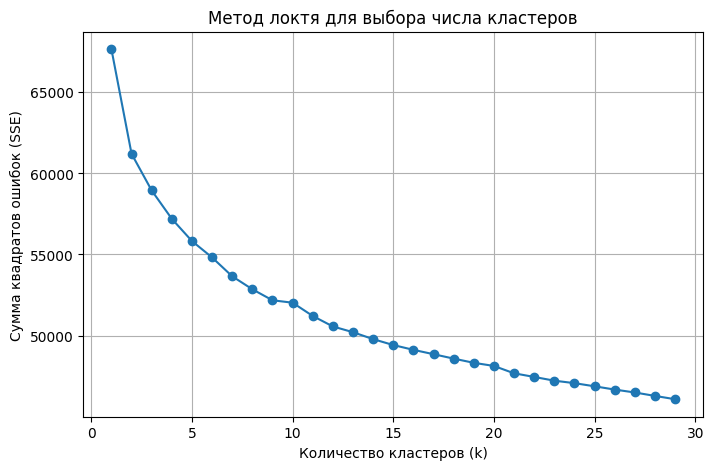

In [34]:
sse = []  # Сумма квадратов ошибок для каждого числа кластеров
k_range = range(1, 30)  # Проверяем количество кластеров от 1 до 15

for k in tqdm(k_range):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embeddings)
    sse.append(kmeans.inertia_)  # inertia_ — сумма квадратов расстояний до центров кластеров

# Построение графика метода локтя
plt.figure(figsize=(8, 5))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Сумма квадратов ошибок (SSE)')
plt.title('Метод локтя для выбора числа кластеров')
plt.grid(True)
plt.show()

In [ ]:
# Применяем K-means кластеризацию
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=11)
clusters = kmeans.fit_predict(embeddings)

# Добавляем метки кластеров (топиков) в DataFrame
df_filtered['topic_cluster'] = clusters

# Для интерпретации можно посмотреть ключевые слова из топ 10 текстов каждого кластера
for cluster_num in range(num_clusters):
    print(f"Cluster {cluster_num}:")
    cluster_texts = df_filtered[df_filtered['topic_cluster'] == cluster_num]['text'].tolist()
    # Здесь можно вывести примерные ключевые слова или топ текстов для определения тематики
    for text in cluster_texts[:10]:
        print(f" - {text}...")
    print()

In [36]:
score = silhouette_score(embeddings, clusters)
print(f"Силуэтное значение кластеризации: {score:.4f}")

Силуэтное значение кластеризации: 0.0360


In [37]:
# Словарь с названиями кластеров
cluster_names = {
    0: "Помощь приютам и благотворительность",
    1: "Поиск дома для отдельных котиков",
    2: "Мероприятия и акции в поддержку животных",
    3: "Истории спасения и просьбы о помощи",
    4: "Распределение и поиск новых хозяев",
    5: "Социальные проекты и просветительская работа",
    6: "Экстренная помощь и спасение животных",
    7: "Теплые истории и забота о животных",
    8: "Особенные случаи и истории болезни",
    9: "Прощания, память и истории"
}

# Добавляем новый столбец с названиями кластеров
df_filtered['cluster_name'] = df_filtered['topic_cluster'].map(cluster_names)


/tmp/ipython-input-3292349855.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['cluster_name'] = df_filtered['topic_cluster'].map(cluster_names)


In [38]:
df_filtered

,date,text,comments.count,likes.count,reposts.count,views.count,id,hour,time_of_day,day_of_week,month,is_weekend,season,textPreprocessed,adjectives,sentiment_score,topic_cluster,cluster_name
0,2025-08-29 13:11:54,Этого светлячка зовут Чапек. И каждую минуту е...,2.0,99.0,38.0,6018.0,267316,13,день,4,8,False,лето,светлячок звать чапек минута мозг превращаться...,маленький частично зрительный сохранный малень...,neutral,8,Особенные случаи и истории болезни
1,2025-09-03 10:01:06,Самый добрый фестиваль [club232253162|КОТОПЁC]...,0.0,12.0,2.0,147.0,267619,10,утро,2,9,False,осень,самый добрый фестиваль club232253162 котопес 7...,самый добрый большой семейный бездомный добрый...,positive,2,Мероприятия и акции в поддержку животных
2,2025-09-03 08:00:00,#ищу_дом@matroskinperm \n \nПрекрасная Сиеста ...,0.0,42.0,2.0,419.0,267612,8,утро,2,9,False,осень,искать дом matroskinperm прекрасный сиеста иск...,прекрасный хрупкий одиноко оживленный несчастн...,positive,3,Истории спасения и просьбы о помощи
3,2025-09-03 06:00:00,Оказываем информационную помощь. Кошка не явля...,0.0,75.0,9.0,1090.0,267606,6,утро,2,9,False,осень,оказывать информационный помощь кошка являться...,информационный предположительно персиковый сух...,neutral,4,Распределение и поиск новых хозяев
4,2025-09-02 12:00:00,#ищу_дом@matroskinperm \n \nЛюбопытная Феста и...,0.0,74.0,7.0,857.0,267583,12,день,1,9,False,осень,искать дом matroskinperm любопытный фест искат...,любопытный похожий маленький бесконечный больш...,neutral,3,Истории спасения и просьбы о помощи
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20422,2017-01-02 15:05:12,"«Дельфины не любят развлекать зрителей, но дел...",0.0,24.0,7.0,1985.0,50007,15,день,0,1,False,зима,дельфин любить развлекать зритель делать еда о...,подобный российский антарктический бывший морс...,positive,5,Социальные проекты и просветительская работа
20423,2017-01-02 13:09:02,Юный Адольф надеется на встречу с самым лучшим...,3.0,30.0,7.0,1896.0,50005,13,день,0,1,False,зима,юный адольф надеяться встреча самый хороший хо...,юный самый хороший черный белый янтарный смешн...,positive,7,Теплые истории и забота о животных
20424,2017-01-02 10:07:00,#ищу_дом@zzzperm \nЧерныш ждет доброе человече...,0.0,33.0,13.0,1926.0,50004,10,утро,0,1,False,зима,искать дом zzzperm черныш ждать добрый человеч...,добрый человеческий спокойный домашний отзывчи...,positive,3,Истории спасения и просьбы о помощи
20425,2017-01-02 08:12:01,"Очередное доказательство того, что коты — это ...",1.0,73.0,3.0,2812.0,50002,8,утро,0,1,False,зима,очередной доказательство кот жидкость,очередной,negative,7,Теплые истории и забота о животных


In [39]:
# Функция для подсчёта слов в строке
def count_words(text):
    if isinstance(text, str):
        return len(text.split())
    else:
        return 0

# Создаем новый столбец с количеством слов
df_filtered['word_count'] = df_filtered['text'].apply(count_words)

/tmp/ipython-input-549150466.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['word_count'] = df_filtered['text'].apply(count_words)


In [40]:
df_filtered

,date,text,comments.count,likes.count,reposts.count,views.count,id,hour,time_of_day,day_of_week,month,is_weekend,season,textPreprocessed,adjectives,sentiment_score,topic_cluster,cluster_name,word_count
0,2025-08-29 13:11:54,Этого светлячка зовут Чапек. И каждую минуту е...,2.0,99.0,38.0,6018.0,267316,13,день,4,8,False,лето,светлячок звать чапек минута мозг превращаться...,маленький частично зрительный сохранный малень...,neutral,8,Особенные случаи и истории болезни,349
1,2025-09-03 10:01:06,Самый добрый фестиваль [club232253162|КОТОПЁC]...,0.0,12.0,2.0,147.0,267619,10,утро,2,9,False,осень,самый добрый фестиваль club232253162 котопес 7...,самый добрый большой семейный бездомный добрый...,positive,2,Мероприятия и акции в поддержку животных,301
2,2025-09-03 08:00:00,#ищу_дом@matroskinperm \n \nПрекрасная Сиеста ...,0.0,42.0,2.0,419.0,267612,8,утро,2,9,False,осень,искать дом matroskinperm прекрасный сиеста иск...,прекрасный хрупкий одиноко оживленный несчастн...,positive,3,Истории спасения и просьбы о помощи,135
3,2025-09-03 06:00:00,Оказываем информационную помощь. Кошка не явля...,0.0,75.0,9.0,1090.0,267606,6,утро,2,9,False,осень,оказывать информационный помощь кошка являться...,информационный предположительно персиковый сух...,neutral,4,Распределение и поиск новых хозяев,81
4,2025-09-02 12:00:00,#ищу_дом@matroskinperm \n \nЛюбопытная Феста и...,0.0,74.0,7.0,857.0,267583,12,день,1,9,False,осень,искать дом matroskinperm любопытный фест искат...,любопытный похожий маленький бесконечный больш...,neutral,3,Истории спасения и просьбы о помощи,128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20422,2017-01-02 15:05:12,"«Дельфины не любят развлекать зрителей, но дел...",0.0,24.0,7.0,1985.0,50007,15,день,0,1,False,зима,дельфин любить развлекать зритель делать еда о...,подобный российский антарктический бывший морс...,positive,5,Социальные проекты и просветительская работа,717
20423,2017-01-02 13:09:02,Юный Адольф надеется на встречу с самым лучшим...,3.0,30.0,7.0,1896.0,50005,13,день,0,1,False,зима,юный адольф надеяться встреча самый хороший хо...,юный самый хороший черный белый янтарный смешн...,positive,7,Теплые истории и забота о животных,61
20424,2017-01-02 10:07:00,#ищу_дом@zzzperm \nЧерныш ждет доброе человече...,0.0,33.0,13.0,1926.0,50004,10,утро,0,1,False,зима,искать дом zzzperm черныш ждать добрый человеч...,добрый человеческий спокойный домашний отзывчи...,positive,3,Истории спасения и просьбы о помощи,57
20425,2017-01-02 08:12:01,"Очередное доказательство того, что коты — это ...",1.0,73.0,3.0,2812.0,50002,8,утро,0,1,False,зима,очередной доказательство кот жидкость,очередной,negative,7,Теплые истории и забота о животных,8


In [41]:
df_filtered.columns

Index(['date', 'text', 'comments.count', 'likes.count', 'reposts.count',
       'views.count', 'id', 'hour', 'time_of_day', 'day_of_week', 'month',
       'is_weekend', 'season', 'textPreprocessed', 'adjectives',
       'sentiment_score', 'topic_cluster', 'cluster_name', 'word_count'],
      dtype='object')

In [42]:
# Выбираем категориальные столбцы для one-hot кодирования
categorical_cols = ['time_of_day', 'season', 'sentiment_score', 'cluster_name']

# Выполняем one-hot кодирование с drop_first=True, чтобы избежать дамми-ловушки
df_encoded = pd.get_dummies(df_filtered, columns=categorical_cols, drop_first=True)

In [43]:
df_encoded

,date,text,comments.count,likes.count,reposts.count,views.count,id,hour,day_of_week,month,...,sentiment_score_positive,cluster_name_Мероприятия и акции в поддержку животных,cluster_name_Особенные случаи и истории болезни,cluster_name_Поиск дома для отдельных котиков,cluster_name_Помощь приютам и благотворительность,"cluster_name_Прощания, память и истории",cluster_name_Распределение и поиск новых хозяев,cluster_name_Социальные проекты и просветительская работа,cluster_name_Теплые истории и забота о животных,cluster_name_Экстренная помощь и спасение животных
0,2025-08-29 13:11:54,Этого светлячка зовут Чапек. И каждую минуту е...,2.0,99.0,38.0,6018.0,267316,13,4,8,...,False,False,True,False,False,False,False,False,False,False
1,2025-09-03 10:01:06,Самый добрый фестиваль [club232253162|КОТОПЁC]...,0.0,12.0,2.0,147.0,267619,10,2,9,...,True,True,False,False,False,False,False,False,False,False
2,2025-09-03 08:00:00,#ищу_дом@matroskinperm \n \nПрекрасная Сиеста ...,0.0,42.0,2.0,419.0,267612,8,2,9,...,True,False,False,False,False,False,False,False,False,False
3,2025-09-03 06:00:00,Оказываем информационную помощь. Кошка не явля...,0.0,75.0,9.0,1090.0,267606,6,2,9,...,False,False,False,False,False,False,True,False,False,False
4,2025-09-02 12:00:00,#ищу_дом@matroskinperm \n \nЛюбопытная Феста и...,0.0,74.0,7.0,857.0,267583,12,1,9,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20422,2017-01-02 15:05:12,"«Дельфины не любят развлекать зрителей, но дел...",0.0,24.0,7.0,1985.0,50007,15,0,1,...,True,False,False,False,False,False,False,True,False,False
20423,2017-01-02 13:09:02,Юный Адольф надеется на встречу с самым лучшим...,3.0,30.0,7.0,1896.0,50005,13,0,1,...,True,False,False,False,False,False,False,False,True,False
20424,2017-01-02 10:07:00,#ищу_дом@zzzperm \nЧерныш ждет доброе человече...,0.0,33.0,13.0,1926.0,50004,10,0,1,...,True,False,False,False,False,False,False,False,False,False
20425,2017-01-02 08:12:01,"Очередное доказательство того, что коты — это ...",1.0,73.0,3.0,2812.0,50002,8,0,1,...,False,False,False,False,False,False,False,False,True,False


In [44]:
df_encoded.columns

Index(['date', 'text', 'comments.count', 'likes.count', 'reposts.count',
       'views.count', 'id', 'hour', 'day_of_week', 'month', 'is_weekend',
       'textPreprocessed', 'adjectives', 'topic_cluster', 'word_count',
       'time_of_day_день', 'time_of_day_ночь', 'time_of_day_утро',
       'season_зима', 'season_лето', 'season_осень', 'sentiment_score_neutral',
       'sentiment_score_positive',
       'cluster_name_Мероприятия и акции в поддержку животных',
       'cluster_name_Особенные случаи и истории болезни',
       'cluster_name_Поиск дома для отдельных котиков',
       'cluster_name_Помощь приютам и благотворительность',
       'cluster_name_Прощания, память и истории',
       'cluster_name_Распределение и поиск новых хозяев',
       'cluster_name_Социальные проекты и просветительская работа',
       'cluster_name_Теплые истории и забота о животных',
       'cluster_name_Экстренная помощь и спасение животных'],
      dtype='object')

In [45]:
df_encoded.replace({True: 1, False: 0}, inplace=True)
df_encoded

/tmp/ipython-input-2189424462.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_encoded.replace({True: 1, False: 0}, inplace=True)


,date,text,comments.count,likes.count,reposts.count,views.count,id,hour,day_of_week,month,...,sentiment_score_positive,cluster_name_Мероприятия и акции в поддержку животных,cluster_name_Особенные случаи и истории болезни,cluster_name_Поиск дома для отдельных котиков,cluster_name_Помощь приютам и благотворительность,"cluster_name_Прощания, память и истории",cluster_name_Распределение и поиск новых хозяев,cluster_name_Социальные проекты и просветительская работа,cluster_name_Теплые истории и забота о животных,cluster_name_Экстренная помощь и спасение животных
0,2025-08-29 13:11:54,Этого светлячка зовут Чапек. И каждую минуту е...,2.0,99.0,38.0,6018.0,267316,13,4,8,...,0,0,1,0,0,0,0,0,0,0
1,2025-09-03 10:01:06,Самый добрый фестиваль [club232253162|КОТОПЁC]...,0.0,12.0,2.0,147.0,267619,10,2,9,...,1,1,0,0,0,0,0,0,0,0
2,2025-09-03 08:00:00,#ищу_дом@matroskinperm \n \nПрекрасная Сиеста ...,0.0,42.0,2.0,419.0,267612,8,2,9,...,1,0,0,0,0,0,0,0,0,0
3,2025-09-03 06:00:00,Оказываем информационную помощь. Кошка не явля...,0.0,75.0,9.0,1090.0,267606,6,2,9,...,0,0,0,0,0,0,1,0,0,0
4,2025-09-02 12:00:00,#ищу_дом@matroskinperm \n \nЛюбопытная Феста и...,0.0,74.0,7.0,857.0,267583,12,1,9,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20422,2017-01-02 15:05:12,"«Дельфины не любят развлекать зрителей, но дел...",0.0,24.0,7.0,1985.0,50007,15,0,1,...,1,0,0,0,0,0,0,1,0,0
20423,2017-01-02 13:09:02,Юный Адольф надеется на встречу с самым лучшим...,3.0,30.0,7.0,1896.0,50005,13,0,1,...,1,0,0,0,0,0,0,0,1,0
20424,2017-01-02 10:07:00,#ищу_дом@zzzperm \nЧерныш ждет доброе человече...,0.0,33.0,13.0,1926.0,50004,10,0,1,...,1,0,0,0,0,0,0,0,0,0
20425,2017-01-02 08:12:01,"Очередное доказательство того, что коты — это ...",1.0,73.0,3.0,2812.0,50002,8,0,1,...,0,0,0,0,0,0,0,0,1,0


In [46]:
df_encoded.columns

Index(['date', 'text', 'comments.count', 'likes.count', 'reposts.count',
       'views.count', 'id', 'hour', 'day_of_week', 'month', 'is_weekend',
       'textPreprocessed', 'adjectives', 'topic_cluster', 'word_count',
       'time_of_day_день', 'time_of_day_ночь', 'time_of_day_утро',
       'season_зима', 'season_лето', 'season_осень', 'sentiment_score_neutral',
       'sentiment_score_positive',
       'cluster_name_Мероприятия и акции в поддержку животных',
       'cluster_name_Особенные случаи и истории болезни',
       'cluster_name_Поиск дома для отдельных котиков',
       'cluster_name_Помощь приютам и благотворительность',
       'cluster_name_Прощания, память и истории',
       'cluster_name_Распределение и поиск новых хозяев',
       'cluster_name_Социальные проекты и просветительская работа',
       'cluster_name_Теплые истории и забота о животных',
       'cluster_name_Экстренная помощь и спасение животных'],
      dtype='object')

In [49]:
df_encoded.to_csv('prepared_data.csv')